##  Piza Nava Vladimir - 111-494


## Laboratorio 3

## Link al repositorio: https://github.com/vladi-13/Laboratorios/blob/main/Laboratorio3.ipynb

## Link al dataset: https://www.kaggle.com/datasets/vladi13/dataset-flores-piza-nava-vladimir

Este código configura el entorno para entrenar una red neuronal en **PyTorch** utilizando **DirectML**, una alternativa a CUDA para GPUs AMD.  

###  Configuración del Dispositivo  
Se obtiene el dispositivo disponible con **DirectML** y se fija una semilla aleatoria (`torch.manual_seed(42)`) para asegurar que los experimentos sean reproducibles.  

###  Mensaje de Confirmación  
Se imprime el dispositivo en uso para verificar que DirectML está funcionando correctamente.  

In [1]:
import torch
import torch_directml
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Configurar el dispositivo DirectML
device = torch_directml.device()
torch.manual_seed(42)  # Para reproducibilidad

print(f"Usando dispositivo: {device}")

Usando dispositivo: privateuseone:0


Este código realiza lo siguiente:

1. **Cargar datos**: Lee un archivo CSV con rutas de imágenes y etiquetas, creando un mapeo de clases a números.
2. **Dividir datos**: Utiliza `train_test_split` para separar el dataset en 80% entrenamiento y 20% validación.
3. **Transformaciones**: Redimensiona las imágenes a 64x64, las convierte a tensores y las normaliza.
4. **Dataset personalizado**: Crea una clase `FlowerDataset` que carga y transforma las imágenes y etiquetas.
5. **DataLoaders**: Crea `DataLoader` para cargar los datos en lotes durante el entrenamiento y validación.
6. **Imprimir tamaño**: Muestra el número de ejemplos en entrenamiento y validación.

Esto organiza los datos para el modelo de manera eficiente.

In [2]:
from sklearn.model_selection import train_test_split

# Cargar CSV
csv_path = "dataset_flores.csv"  # Ajusta la ruta según corresponda
data = pd.read_csv(csv_path)

# Crear un mapeo de clases a números
class_mapping = {name: idx for idx, name in enumerate(sorted(data.iloc[:, 1].unique()))}
print("Mapa de clases:", class_mapping)  # Verificar el mapeo

# Dividir el dataset en 80% entrenamiento y 20% validación
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data.iloc[:, 1], random_state=42)

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Reducir resolución
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Definir clase del dataset personalizado
class FlowerDataset(Dataset):
    def __init__(self, csv_data, transform=None):
        self.data = csv_data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index, 0]  # Primera columna: rutas de imágenes
        label = self.data.iloc[index, 1]     # Segunda columna: etiquetas de clases
        label = class_mapping[label]         # Convertir la etiqueta a entero

        # Abrir imagen
        image = Image.open(img_path).convert("RGB")

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label

# Crear datasets de entrenamiento y validación
train_dataset = FlowerDataset(train_data, transform=transform)
val_dataset = FlowerDataset(val_data, transform=transform)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

print(f"Dataset dividido: {len(train_dataset)} entrenamiento, {len(val_dataset)} validación")

Mapa de clases: {'Astromelia': 0, 'Cartucho': 1, 'Lirio': 2, 'Obispo': 3, 'SanJuan': 4}
Dataset dividido: 40000 entrenamiento, 10000 validación


Este código define una red neuronal convolucional (CNN) con tres bloques convolucionales seguidos de capas totalmente conectadas:

1. **Capas convolucionales**: Extraen características de la imagen mediante convoluciones, normalización, activación ReLU y max pooling.
2. **Capas totalmente conectadas**: Aplanan las características extraídas y las pasan por capas densas para la predicción final.

El modelo se utiliza para clasificación de imágenes en `num_classes` clases.

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Primer bloque convolucional
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Segundo bloque convolucional
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Tercer bloque convolucional
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce a (128, 8, 8)
        )

        # Capas totalmente conectadas
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),  # Tamaño corregido
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    # Definir el flujo hacia adelante
    def forward(self, x):
        x = self.conv_layers(x) # Pasar por las capas convolucionales
        x = x.view(x.size(0), -1)  # Aplanar para la capa totalmente conectada
        x = self.fc_layers(x) # Pasar por las capas totalmente conectadas
        return x

Este código define:

1. **Modelo CNN**: Crea una instancia del modelo `CNN` con 5 clases y lo mueve al dispositivo (CPU o GPU).
2. **Función de pérdida**: Usa `CrossEntropyLoss` para clasificación multiclase.
3. **Optimizador**: Utiliza `AdamW` con una tasa de aprendizaje de 0.001 y decaimiento de peso de 1e-4.
4. **Épocas y paciencia**: Establece 10 épocas de entrenamiento y 2 épocas de paciencia para early stopping.

In [4]:
import torch.optim as optim

# Definir modelo antes de usarlo
model = CNN(num_classes=5).to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Número de épocas y paciencia
epochs = 10
patience = 2

Este código entrena el modelo con el siguiente flujo:

1. **Entrenamiento**: En cada época, se entrena el modelo con `train_loader`, calculando la pérdida y actualizando los pesos usando el optimizador.
2. **Evaluación de validación**: Se evalúa el modelo con `val_loader` después de cada época para calcular la pérdida de validación.
3. **Early Stopping**: Si la pérdida de validación no mejora después de un número determinado de épocas (`patience`), el entrenamiento se detiene.
4. **Guardado del mejor modelo**: Si la pérdida de validación mejora, se guarda el modelo.

In [6]:
from tqdm import tqdm

best_val_loss = float("inf")
counter = 0  # Contador de épocas sin mejora

for epoch in range(epochs):
    model.train() # Modo de entrenamiento
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Época {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device, dtype=torch.long)

        optimizer.zero_grad() # Inicializar gradientes
        outputs = model(images) # Propagación hacia adelante    
        loss = criterion(outputs, labels) # Calcular pérdida
        loss.backward() # Propagación hacia atrás               
        optimizer.step() # Actualizar pesos

        running_loss += loss.item() # Acumular pérdida

    # Calcular pérdida de entrenamiento
    train_loss = running_loss / len(train_loader)
    print(f"Época {epoch+1} - Pérdida de entrenamiento: {train_loss:.4f}")

    # Evaluación en validación (si tienes val_loader)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:  # Usa val_loader si tienes
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Época {epoch+1} - Pérdida de validación: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_lab3.pth")
        print("✅ Modelo mejorado y guardado.")
    else:
        counter += 1
        print(f"🔸 No hay mejora. Paciencia: {counter}/{patience}")

    if counter >= patience:
        print("⏹️ Early Stopping activado. Deteniendo entrenamiento.")
        break

Época 1/10: 100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


Época 1 - Pérdida de entrenamiento: 0.0253
Época 1 - Pérdida de validación: 0.0190
✅ Modelo mejorado y guardado.


Época 2/10: 100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


Época 2 - Pérdida de entrenamiento: 0.0172
Época 2 - Pérdida de validación: 0.0372
🔸 No hay mejora. Paciencia: 1/2


Época 3/10: 100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


Época 3 - Pérdida de entrenamiento: 0.0156
Época 3 - Pérdida de validación: 0.0139
✅ Modelo mejorado y guardado.


Época 4/10: 100%|██████████| 157/157 [02:42<00:00,  1.03s/it]


Época 4 - Pérdida de entrenamiento: 0.0138
Época 4 - Pérdida de validación: 0.0379
🔸 No hay mejora. Paciencia: 1/2


Época 5/10: 100%|██████████| 157/157 [02:42<00:00,  1.04s/it]


Época 5 - Pérdida de entrenamiento: 0.0112
Época 5 - Pérdida de validación: 0.0084
✅ Modelo mejorado y guardado.


Época 6/10: 100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


Época 6 - Pérdida de entrenamiento: 0.0066
Época 6 - Pérdida de validación: 0.0096
🔸 No hay mejora. Paciencia: 1/2


Época 7/10: 100%|██████████| 157/157 [02:42<00:00,  1.03s/it]


Época 7 - Pérdida de entrenamiento: 0.0089
Época 7 - Pérdida de validación: 0.0105
🔸 No hay mejora. Paciencia: 2/2
⏹️ Early Stopping activado. Deteniendo entrenamiento.


Este código carga el modelo previamente entrenado y guarda los pesos del mejor modelo. Luego evalúa el modelo con un conjunto de datos de validación (`val_loader`) calculando la **precisión** y la **pérdida promedio**.

1. **Carga del modelo**: El modelo se carga con los pesos guardados en `best_model_lab3.pth`.
2. **Evaluación del modelo**: Se evalúa el modelo en el conjunto de validación con el cálculo de la precisión y la pérdida.
3. **Salida**: Imprime la precisión y la pérdida promedio en la consola.

In [7]:
# Cargar el modelo guardado
model = CNN(num_classes=5).to(device)  # Asegúrate de definir la arquitectura
model.load_state_dict(torch.load("best_model_lab3.pth", map_location=device))  # Cargar pesos
model.eval()  # Modo evaluación

def evaluar_modelo(model, val_loader, criterion, device):
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)

    print(f'Precisión: {accuracy:.2f}% - Pérdida Promedio: {avg_loss:.4f}')
    return accuracy, avg_loss

# Evaluar el modelo cargado
accuracy, loss = evaluar_modelo(model, train_loader, criterion, device)

C:\Users\vladi\AppData\Local\Temp\ipykernel_3620\544641138.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_lab3.pth", map_lo

Precisión: 99.95% - Pérdida Promedio: 0.0017


Este código realiza las siguientes tareas:

1. **Lista de clases**: Define las clases de flores (como "astromelia", "cartucho", etc.).
2. **Selección aleatoria de imagen**: Lee un CSV que contiene rutas de imágenes y sus respectivas etiquetas. Selecciona una imagen al azar y devuelve su ruta y etiqueta.
3. **Predicción de imagen**: Carga una imagen desde la ruta seleccionada, la transforma y la pasa por el modelo entrenado para obtener la predicción.
4. **Mostrar imagen y predicción**: Si se encuentra una imagen en el CSV, se predice su clase y se muestra la imagen junto con la predicción y la clase real.

- Si no se encuentran imágenes en el CSV, se muestra un mensaje de advertencia.

C:\Users\vladi\AppData\Local\Temp\ipykernel_3620\4024906033.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_lab3.pth", map_

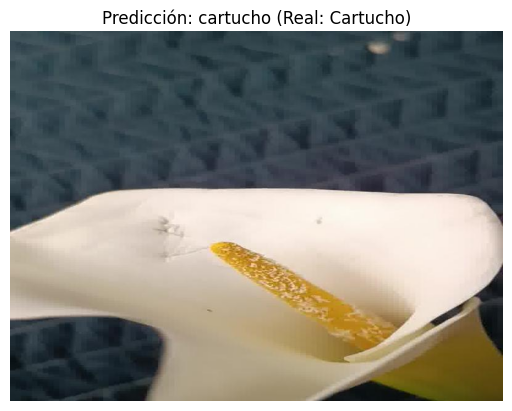

In [24]:
# Lista de clases
class_names = ["astromelia", "cartucho", "lirio", "obispo", "sanjuan"]

def elegir_imagen_aleatoria(csv_path="dataset_flores.csv"):
    """Selecciona aleatoriamente una imagen desde un CSV con rutas y clases."""
    df = pd.read_csv(csv_path)
    
    if df.empty:
        return None, None
    
    fila = df.sample(n=1).iloc[0]  # Seleccionar una fila aleatoria
    return fila["image_path"], fila["label"]

def predecir_imagen(model, image_path, class_names, device):
    """Carga una imagen, la pasa por el modelo y devuelve la predicción."""
    image = Image.open(image_path).convert("RGB")  # Cargar la imagen
    image_tensor = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

    prediccion = class_names[predicted.item()]  # Convertir índice a nombre de clase
    return image, prediccion

# Cargar modelo guardado
model = CNN(num_classes=5).to(device)
model.load_state_dict(torch.load("best_model_lab3.pth", map_location=device))
model.eval()

# Predecir una imagen aleatoria desde el CSV
image_path, clase_real = elegir_imagen_aleatoria()
if image_path:
    image, prediccion = predecir_imagen(model, image_path, class_names, device)

    # Mostrar la imagen con su predicción y clase real
    plt.imshow(image)
    plt.title(f'Predicción: {prediccion} (Real: {clase_real})')
    plt.axis('off')
    plt.show()
else:
    print("No se encontraron imágenes en el CSV.")